# Lab 5: Neural Network Classification with scikit-learn

---
## 1. Notebook Overview

### 1.1 Objective
Build a Multi-Layer Perceptron (MLP) neural network for multi-label tweet topic classification using scikit-learn's `MLPClassifier`.

### 1.2 Prerequisites
This notebook assumes you have already executed:
- **Lab 2**: Data preprocessing → `../Data/tweets_preprocessed_train.parquet`, `../Data/tweets_preprocessed_test.parquet`, `../Data/tweets_preprocessed_validation.parquet`
- **Lab 3**: Language modeling
- **Lab 4**: Feature extraction → `../Data/top_1000_vocabulary.json`

### 1.3 Architecture
We implement a neural network with:
- **Input layer**: 1000 features (Top 1000 vocabulary from Lab 4)
- **Hidden layers**: 128 → 64 → 128 neurons (as specified)
- **Output layer**: 19 neurons (one per topic class)

### 1.4 Data Splits
- **Training**: `../Data/tweets_preprocessed_train.parquet` (from Lab 2)
- **Validation**: `../Data/tweets_preprocessed_validation.parquet` (from Lab 2)
- **Test**: `../Data/tweets_preprocessed_test.parquet` (from Lab 2)

### 1.5 Section Roadmap
1. `Section 2`: Load data and vocabulary
2. `Section 3`: Feature extraction using Top 1000 vocabulary from Lab 4
3. `Section 4`: Build and train the MLP neural network
4. `Section 5`: Evaluate on validation and test sets
5. `Section 6`: Architecture comparison and analysis

---
## 2.  Data Loading

Load preprocessed training data from Lab 2, the vocabulary from Lab 4, and preprocessed test/validation splits from Lab 2.

In [1]:
%pip install scikit-learn pandas numpy datasets matplotlib seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import pandas as pd
import numpy as np
import ast
from typing import List
import warnings
warnings.filterwarnings('ignore')

# Constants - paths to Lab 2 and Lab 4 outputs
TRAIN_DATA_PATH = "../Data/tweets_preprocessed_train.parquet"
TEST_DATA_PATH = "../Data/tweets_preprocessed_test.parquet"
VALIDATION_DATA_PATH = "../Data/tweets_preprocessed_validation.parquet"
VOCABULARY_PATH = "../Data/top_1000_vocabulary.json"
RANDOM_STATE = 42

# The 19 topic labels in the dataset
TOPIC_LABELS = [
    'arts_&_culture', 'business_&_entrepreneurs', 'celebrity_&_pop_culture',
    'diaries_&_daily_life', 'family', 'fashion_&_style', 'film_tv_&_video',
    'fitness_&_health', 'food_&_dining', 'gaming', 'learning_&_educational',
    'music', 'news_&_social_concern', 'other_hobbies', 'relationships',
    'science_&_technology', 'sports', 'travel_&_adventure', 'youth_&_student_life'
]
NUM_CLASSES = len(TOPIC_LABELS)

print(f"Number of topic classes: {NUM_CLASSES}")

Number of topic classes: 19


In [3]:
# Load the Top 1000 vocabulary from Lab 4
print("Loading vocabulary from Lab 4...")
with open(VOCABULARY_PATH, 'r', encoding='utf-8') as f:
    vocab_data = json.load(f)

TOP_VOCABULARY = vocab_data['tokens']

print(f"✓ Loaded vocabulary from: {VOCABULARY_PATH}")
print(f"✓ Vocabulary size: {len(TOP_VOCABULARY)}")
print(f"✓ First 10 tokens: {TOP_VOCABULARY[:10]}")
print(f"✓ Description: {vocab_data. get('description', 'N/A')}")

Loading vocabulary from Lab 4...
✓ Loaded vocabulary from: ../Data/top_1000_vocabulary.json
✓ Vocabulary size: 1000
✓ First 10 tokens: ['new', 'day', 'love', 'good', 'game', 'year', 'time', 'watch', 'happy', 'music']
✓ Description: Top 1000 most frequent tokens from preprocessed tweets (Lab 4)


In [4]:
def parse_label_vector(value) -> np.ndarray:
    """Parse the label column (binary vector) to numpy array."""
    if isinstance(value, np.ndarray):
        return value. astype(np. float32)
    if isinstance(value, list):
        return np.array(value, dtype=np.float32)
    if isinstance(value, str):
        # Handle string representation like '[0 0 0 1 0 ...]'
        cleaned = value.strip('[]'). split()
        return np.array([float(x) for x in cleaned], dtype=np.float32)
    return np.zeros(NUM_CLASSES, dtype=np. float32)


# Load preprocessed training data from Lab 2
print("\nLoading preprocessed training data from Lab 2...")
df_train = pd. read_parquet(TRAIN_DATA_PATH)
print(f"Training samples: {len(df_train):,}")
print(f"Columns: {df_train.columns.tolist()}")
df_train. head(3)


Loading preprocessed training data from Lab 2...
Training samples: 6,090
Columns: ['text', 'label_name', 'label']


,text,label_name,label
0,lumber beat rapid game western division final ...,['sports'],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,hear eli gold announce auburn game dumbass,['sports'],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,phone away try look home game ticket october,['sports'],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
# Load preprocessed test and validation data from Lab 2
print("Loading preprocessed test and validation data...")

df_test = pd.read_parquet(TEST_DATA_PATH)
df_val = pd.read_parquet(VALIDATION_DATA_PATH)

print(f"Test samples: {len(df_test):,}")
print(f"Validation samples: {len(df_val):,}")

Loading preprocessed test and validation data...
Test samples: 1,679
Validation samples: 188


In [6]:
# Extract labels - use the 'label' column which contains binary vectors
y_train = np.array([parse_label_vector(lbl) for lbl in df_train['label']])
y_test = np.array([parse_label_vector(lbl) for lbl in df_test['label']])
y_val = np.array([parse_label_vector(lbl) for lbl in df_val['label']])

print(f"\nLabel matrix shapes:")
print(f"  y_train: {y_train.shape}")
print(f"  y_test: {y_test.shape}")
print(f"  y_val: {y_val.shape}")

# Verify label distribution
print(f"\nTraining set label distribution:")
for i, label in enumerate(TOPIC_LABELS[:5]):
    count = int(y_train[:, i].sum())
    print(f"  {label}: {count} ({count/len(y_train)*100:.1f}%)")
print(f"  ...  (showing 5 of {NUM_CLASSES} classes)")


Label matrix shapes:
  y_train: (6090, 19)
  y_test: (1679, 19)
  y_val: (188, 19)

Training set label distribution:
  arts_&_culture: 298 (4.9%)
  business_&_entrepreneurs: 288 (4.7%)
  celebrity_&_pop_culture: 924 (15.2%)
  diaries_&_daily_life: 866 (14.2%)
  family: 252 (4.1%)
  ...  (showing 5 of 19 classes)


---
## 3. Feature Extraction

### 3.1 Using the Top 1000 Vocabulary from Lab 4
Instead of creating a new vocabulary, we reuse the top 1000 tokens extracted in Lab 4.  This ensures consistency across the pipeline and avoids redundant computation.

### 3.2 TF-IDF Vectorization
We use TF-IDF weighting with the predefined vocabulary to create feature vectors.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use the Top 1000 vocabulary from Lab 4
tfidf_vectorizer = TfidfVectorizer(
    vocabulary=TOP_VOCABULARY,  # Predefined vocabulary from Lab 4
    lowercase=True,
)

# Transform all splits using the predefined vocabulary
print("Vectorizing text data using Lab 4 vocabulary...")
X_train = tfidf_vectorizer.fit_transform(df_train['text']. astype(str))
X_test = tfidf_vectorizer.transform(df_test['text'].astype(str))
X_val = tfidf_vectorizer.transform(df_val['text'].astype(str))

print(f"\nFeature matrix shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test. shape}")
print(f"  X_val: {X_val.shape}")
print(f"\nVocabulary size: {len(tfidf_vectorizer.get_feature_names_out())} (from Lab 4)")
print(f"Sample features: {tfidf_vectorizer.get_feature_names_out()[:10]. tolist()}")

Vectorizing text data using Lab 4 vocabulary...

Feature matrix shapes:
  X_train: (6090, 1000)
  X_test: (1679, 1000)
  X_val: (188, 1000)

Vocabulary size: 1000 (from Lab 4)
Sample features: ['new', 'day', 'love', 'good', 'game', 'year', 'time', 'watch', 'happy', 'music']


---
## 4.  Neural Network Model

### 4. 1 Architecture
As specified in the lab requirements:
- **Input layer**: 1000 features (Top 1000 vocabulary from Lab 4)
- **Hidden layer 1**: 128 neurons
- **Hidden layer 2**: 64 neurons
- **Hidden layer 3**: 128 neurons
- **Output layer**: 19 neurons (one per topic)

### 4.2 Why no early_stopping?
We have dedicated validation (`validation_2021`) and test (`test_2021`) splits from HuggingFace. There's no need for scikit-learn to internally split the training data for early stopping validation.

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
import time

# Architecture as specified: 128 -> 64 -> 128
HIDDEN_LAYERS = (128, 64, 128)

print("=" * 60)
print("NEURAL NETWORK CONFIGURATION")
print("=" * 60)
print(f"Input layer: {X_train.shape[1]} features (Top 1000 from Lab 4)")
print(f"Hidden layers: {HIDDEN_LAYERS}")
print(f"Output layer: {NUM_CLASSES} classes")
print("=" * 60)

# Create MLP classifier
# No early_stopping - we use HuggingFace's validation_2021 for model selection
mlp_base = MLPClassifier(
    hidden_layer_sizes=HIDDEN_LAYERS,
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=200,
    random_state=RANDOM_STATE,
    verbose=True
)

# Wrap for multi-label classification
mlp_classifier = MultiOutputClassifier(mlp_base, n_jobs=-1)

print("\n✓ Model created successfully")

NEURAL NETWORK CONFIGURATION
Input layer: 1000 features (Top 1000 from Lab 4)
Hidden layers: (128, 64, 128)
Output layer: 19 classes

✓ Model created successfully


In [9]:
# Train the model
print("\n" + "=" * 60)
print("TRAINING")
print("=" * 60)

start_time = time.time()
mlp_classifier.fit(X_train, y_train)
training_time = time. time() - start_time

print(f"\n✓ Training completed in {training_time:.2f} seconds")

# Check convergence
converged = sum(1 for est in mlp_classifier.estimators_ if est.n_iter_ < est.max_iter)
print(f"✓ {converged}/{NUM_CLASSES} classifiers converged before max_iter")


TRAINING
Iteration 1, loss = 0.47879908
Iteration 1, loss = 0.47446338
Iteration 2, loss = 0.18552682
Iteration 2, loss = 0.18058630
Iteration 1, loss = 0.55207665
Iteration 3, loss = 0.15051933
Iteration 3, loss = 0.15834571
Iteration 1, loss = 0.47106813
Iteration 2, loss = 0.39539668
Iteration 4, loss = 0.13669230
Iteration 1, loss = 0.55313979
Iteration 1, loss = 0.54621519
Iteration 4, loss = 0.12319547
Iteration 1, loss = 0.45349226
Iteration 2, loss = 0.15451212
Iteration 1, loss = 0.47442996
Iteration 3, loss = 0.33979595
Iteration 1, loss = 0.45971694
Iteration 5, loss = 0.09743566
Iteration 2, loss = 0.38015596
Iteration 5, loss = 0.11298322
Iteration 2, loss = 0.38582764
Iteration 3, loss = 0.11788787
Iteration 2, loss = 0.08015674
Iteration 2, loss = 0.17736937
Iteration 4, loss = 0.28380663
Iteration 1, loss = 0.56177892
Iteration 2, loss = 0.11759212
Iteration 6, loss = 0.07531950
Iteration 1, loss = 0.47159996
Iteration 1, loss = 0.45832973
Iteration 3, loss = 0.3210346

---
## 5.  Model Evaluation

Evaluate on both validation and test sets.

In [10]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    hamming_loss, classification_report
)

# Predictions
y_pred_val = mlp_classifier.predict(X_val)
y_pred_test = mlp_classifier.predict(X_test)

def evaluate(y_true, y_pred, split_name):
    """Print evaluation metrics for a given split."""
    print(f"\n{'='*60}")
    print(f"{split_name. upper()} SET METRICS")
    print("="*60)
    print(f"{'Subset Accuracy':<20}: {accuracy_score(y_true, y_pred):.4f}")
    print(f"{'Hamming Loss':<20}: {hamming_loss(y_true, y_pred):.4f}")
    print(f"{'Micro F1':<20}: {f1_score(y_true, y_pred, average='micro', zero_division=0):.4f}")
    print(f"{'Macro F1':<20}: {f1_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
    print(f"{'Weighted F1':<20}: {f1_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")
    print(f"{'Micro Precision':<20}: {precision_score(y_true, y_pred, average='micro', zero_division=0):.4f}")
    print(f"{'Micro Recall':<20}: {recall_score(y_true, y_pred, average='micro', zero_division=0):.4f}")

# Evaluate on validation set (for model selection)
evaluate(y_val, y_pred_val, "Validation")

# Evaluate on test set (final performance)
evaluate(y_test, y_pred_test, "Test")


VALIDATION SET METRICS
Subset Accuracy     : 0.3457
Hamming Loss        : 0.0546
Micro F1            : 0.6029
Macro F1            : 0.2515
Weighted F1         : 0.5629
Micro Precision     : 0.7255
Micro Recall        : 0.5157

TEST SET METRICS
Subset Accuracy     : 0.3502
Hamming Loss        : 0.0618
Micro F1            : 0.5587
Macro F1            : 0.3502
Weighted F1         : 0.5378
Micro Precision     : 0.6690
Micro Recall        : 0.4796


In [11]:
# Per-class performance on test set
print("\n" + "=" * 60)
print("PER-CLASS PERFORMANCE (Test Set)")
print("=" * 60)

print(classification_report(
    y_test, y_pred_test,
    target_names=TOPIC_LABELS,
    zero_division=0
))


PER-CLASS PERFORMANCE (Test Set)
                          precision    recall  f1-score   support

          arts_&_culture       0.24      0.10      0.14        48
business_&_entrepreneurs       0.44      0.32      0.37        78
 celebrity_&_pop_culture       0.45      0.24      0.31       245
    diaries_&_daily_life       0.33      0.20      0.25       149
                  family       0.64      0.50      0.56        32
         fashion_&_style       0.36      0.16      0.22        32
         film_tv_&_video       0.67      0.42      0.51       298
        fitness_&_health       0.46      0.29      0.35        56
           food_&_dining       0.31      0.27      0.29        15
                  gaming       0.55      0.30      0.39        77
  learning_&_educational       0.30      0.10      0.15        29
                   music       0.87      0.71      0.78       380
   news_&_social_concern       0.58      0.50      0.54       327
           other_hobbies       0.27      

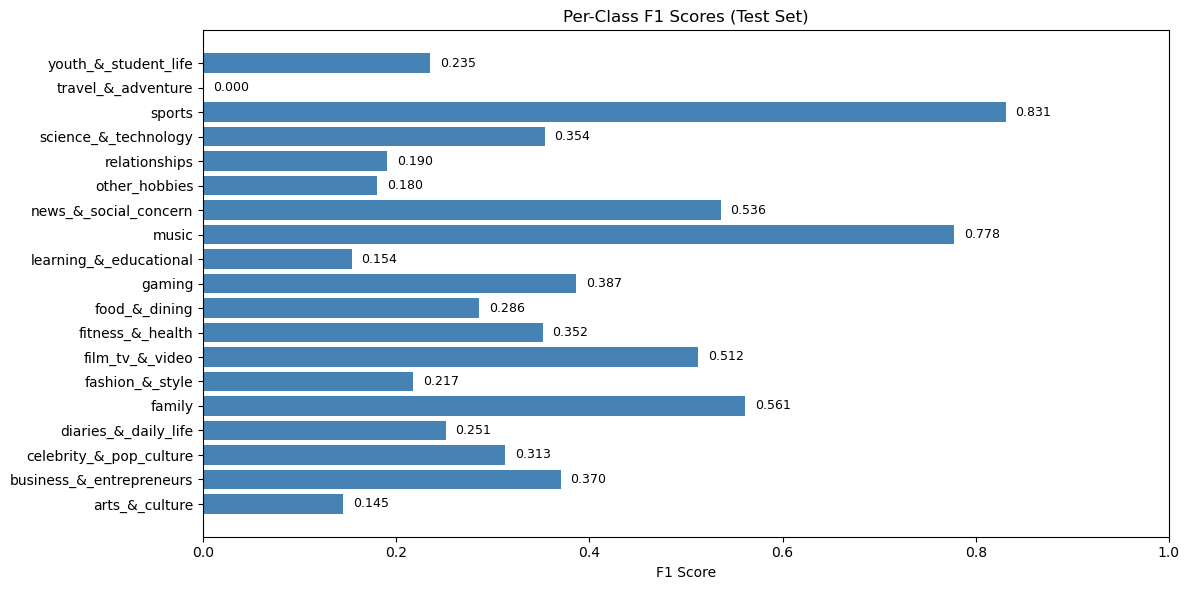

In [12]:
import matplotlib.pyplot as plt

# Visualize per-class F1 scores
per_class_f1 = f1_score(y_test, y_pred_test, average=None, zero_division=0)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(TOPIC_LABELS, per_class_f1, color='steelblue')
ax.set_xlabel('F1 Score')
ax.set_title('Per-Class F1 Scores (Test Set)')
ax.set_xlim(0, 1)

for bar, score in zip(bars, per_class_f1):
    ax.text(bar. get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f'{score:.3f}', va='center', fontsize=9)

plt. tight_layout()
plt.show()

---
## 6. Architecture Comparison

Compare different hidden layer configurations.

In [13]:
architectures = [
    (64,),               # Single layer
    (128, 64),           # Two layers
    (128, 64, 128),      # Three layers (baseline)
    (256, 128, 64),      # Wider first layer
]

print("=" * 60)
print("ARCHITECTURE COMPARISON")
print("=" * 60)

results = []

for arch in architectures:
    print(f"\nTraining: {arch}")
    
    mlp = MLPClassifier(
        hidden_layer_sizes=arch,
        activation='relu',
        solver='adam',
        alpha=0.0001,
        learning_rate='adaptive',
        max_iter=100,
        random_state=RANDOM_STATE,
        verbose=False
    )
    
    clf = MultiOutputClassifier(mlp, n_jobs=-1)
    
    start = time.time()
    clf.fit(X_train, y_train)
    train_time = time. time() - start
    
    # Evaluate on VALIDATION set (for model selection)
    y_pred = clf.predict(X_val)
    
    f1_micro = f1_score(y_val, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
    
    results.append({
        'Architecture': str(arch),
        'Micro F1': f1_micro,
        'Macro F1': f1_macro,
        'Train Time (s)': train_time
    })
    
    print(f"  Val Micro F1: {f1_micro:.4f}, Macro F1: {f1_macro:.4f}, Time: {train_time:.1f}s")

results_df = pd. DataFrame(results)
print("\n" + "=" * 60)
print("SUMMARY (Validation Set)")
print("=" * 60)
print(results_df.to_string(index=False))

ARCHITECTURE COMPARISON

Training: (64,)


/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_

  Val Micro F1: 0.5854, Macro F1: 0.2560, Time: 4.0s

Training: (128, 64)
  Val Micro F1: 0.6135, Macro F1: 0.2563, Time: 4.8s

Training: (128, 64, 128)
  Val Micro F1: 0.6029, Macro F1: 0.2515, Time: 5.1s

Training: (256, 128, 64)
  Val Micro F1: 0.6091, Macro F1: 0.2499, Time: 15.7s

SUMMARY (Validation Set)
  Architecture  Micro F1  Macro F1  Train Time (s)
         (64,)  0.585366  0.255950        4.046949
     (128, 64)  0.613546  0.256261        4.787987
(128, 64, 128)  0.602851  0.251540        5.077048
(256, 128, 64)  0.609053  0.249850       15.665211


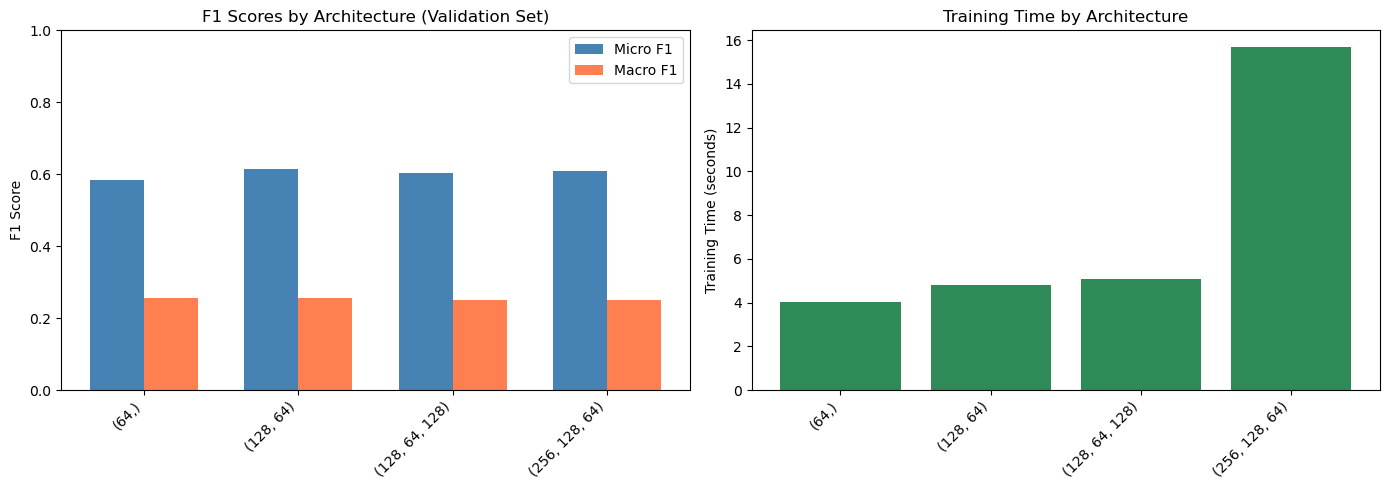

In [14]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = range(len(results_df))
width = 0.35

axes[0]. bar([i - width/2 for i in x], results_df['Micro F1'], width, label='Micro F1', color='steelblue')
axes[0].bar([i + width/2 for i in x], results_df['Macro F1'], width, label='Macro F1', color='coral')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Architecture'], rotation=45, ha='right')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Scores by Architecture (Validation Set)')
axes[0].legend()
axes[0].set_ylim(0, 1)

axes[1].bar(x, results_df['Train Time (s)'], color='seagreen')
axes[1].set_xticks(x)
axes[1]. set_xticklabels(results_df['Architecture'], rotation=45, ha='right')
axes[1].set_ylabel('Training Time (seconds)')
axes[1].set_title('Training Time by Architecture')

plt.tight_layout()
plt.show()

---
## 7. Sample Predictions

In [15]:
def binary_to_labels(binary_vec):
    """Convert binary vector to label names."""
    return [TOPIC_LABELS[i] for i, val in enumerate(binary_vec) if val == 1] or ['[none]']

print("=" * 60)
print("SAMPLE PREDICTIONS (Test Set)")
print("=" * 60)

np.random.seed(RANDOM_STATE)
sample_idx = np.random. choice(len(df_test), size=10, replace=False)

for idx in sample_idx:
    text = df_test['text'].iloc[idx]
    true = binary_to_labels(y_test[idx])
    pred = binary_to_labels(y_pred_test[idx])
    
    match = "✓" if set(true) == set(pred) else "✗"
    
    print(f"\n{match} Sample {idx}:")
    print(f"   Text: {str(text)[:80]}...")
    print(f"   True: {true}")
    print(f"   Pred: {pred}")

SAMPLE PREDICTIONS (Test Set)

✓ Sample 1602:
   Text: curious li angelo ball nba summer league hornet nba twitter nba nba summer leagu...
   True: ['sports']
   Pred: ['sports']

✓ Sample 482:
   Text: game beat cal game man vs ohio state game vs stanford...
   True: ['sports']
   Pred: ['sports']

✗ Sample 203:
   Text: feel like nfc championship packer...
   True: ['sports']
   Pred: ['food_&_dining', 'gaming', 'sports']

✗ Sample 49:
   Text: warzone victory long weekend inside...
   True: ['gaming']
   Pred: ['sports']

✓ Sample 937:
   Text: final conclude take home victory massive congratulation victory inaugural div il...
   True: ['sports']
   Pred: ['sports']

✓ Sample 481:
   Text: omg northwestern fumble ohio state recover bad let goooo state...
   True: ['sports']
   Pred: ['sports']

✗ Sample 1667:
   Text: ominous sign exactly year later hurricane similar katrina threaten devastate new...
   True: ['diaries_&_daily_life', 'news_&_social_concern']
   Pred: ['[none]']

✓ S

---
## 8. Conclusion

### 8.1 Summary
We built an MLP neural network with the specified 128-64-128 architecture for multi-label tweet classification.

### 8.2 Key Design Decisions
- **Top 1000 Vocabulary from Lab 4**: Reusing the vocabulary ensures consistency across the pipeline
- **No early_stopping**: We use HuggingFace's `validation_2021` split for model selection and `test_2021` for final evaluation
- **MultiOutputClassifier wrapper**: Handles multi-label by training 19 independent binary classifiers
- **TF-IDF features**: Captures term importance relative to the corpus

### 8.3 Pipeline Overview
```
Lab 2: Raw tweets → Preprocessing → tweets_preprocessed_train. parquet
Lab 3: Preprocessed tweets → Language Models (Unigram/Bigram)
Lab 4: Preprocessed tweets → Top 1000 Vocabulary → top_1000_vocabulary.json
Lab 5: Preprocessed tweets + Top 1000 Vocabulary → Neural Network → Predictions
```

### 8.4 Limitations of scikit-learn's MLP
- No GPU acceleration
- No dropout or batch normalization
- Limited to fully-connected layers

### 8.5 Next Steps
- Tune regularization (alpha parameter)
- Try different activation functions
- Consider deep learning frameworks (PyTorch/TensorFlow) for more flexibility

In [ ]:
# Final summary
test_f1_micro = f1_score(y_test, y_pred_test, average='micro', zero_division=0)
test_f1_macro = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

print("\n" + "=" * 60)
print("FINAL MODEL SUMMARY")
print("=" * 60)
print(f"Vocabulary: {VOCABULARY_PATH} ({len(TOP_VOCABULARY)} tokens from Lab 4)")
print(f"Architecture: Input({X_train.shape[1]}) → 128 → 64 → 128 → Output({NUM_CLASSES})")
print(f"Training samples: {len(y_train):,}")
print(f"Validation samples: {len(y_val):,}")
print(f"Test samples: {len(y_test):,}")
print(f"Test Micro F1: {test_f1_micro:.4f}")
print(f"Test Macro F1: {test_f1_macro:.4f}")
print("=" * 60)


FINAL MODEL SUMMARY
Vocabulary: ../Data/top_1000_vocabulary.json (1000 tokens from Lab 4)
Architecture: Input(1000) → 128 → 64 → 128 → Output(19)
Training samples: 6,090
Validation samples: 188
Test samples: 1,679
Test Micro F1: 0.5587


ValueError: Format specifier missing precision